In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func, desc

# data
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [14]:
SQL_USERNAME = "postgres"
SQL_PASSWORD = "postgres" # change this
SQL_IP = "localhost"
PORT = 5432
DATABASE = "crowdfunding_db" # change this

In [15]:
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [16]:
# INSPECT

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

contacts_option1
-----------
contact_id INTEGER
first_name VARCHAR(50)
last_name VARCHAR(50)
email VARCHAR(50)

category
-----------
category_id CHAR(4)
category VARCHAR(30)

subcategory
-----------
subcategory_id CHAR(8)
subcategory VARCHAR(30)

campaign
-----------
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description VARCHAR(100)
goal DOUBLE PRECISION
pledged DOUBLE PRECISION
outcome VARCHAR(10)
backers_count INTEGER
country VARCHAR(2)
currency VARCHAR(3)
launch_date TIMESTAMP
end_date TIMESTAMP
category_id CHAR(4)
subcategory_id VARCHAR(8)



In [17]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.contacts_option1'>, <class 'sqlalchemy.ext.automap.category'>, <class 'sqlalchemy.ext.automap.campaign'>, <class 'sqlalchemy.ext.automap.subcategory'>]


In [18]:
query = """
    SELECT
        *
    FROM
        campaign;
"""

campaign_df = pd.read_sql(text(query), con=engine)
campaign_df.head()

,cf_id,contact_id,company_name,description,goal,pledged,outcome,backers_count,country,currency,launch_date,end_date,category_id,subcategory_id
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13 06:00:00,2021-03-01 06:00:00,cat1,subcat1
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400.0,14560.0,successful,158,US,USD,2021-01-25 06:00:00,2021-05-25 05:00:00,cat2,subcat2
2,1812,4187,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure,108400.0,142523.0,successful,1425,AU,AUD,2020-12-17 06:00:00,2021-12-30 06:00:00,cat3,subcat3
3,2156,4941,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration,4200.0,2477.0,failed,24,US,USD,2021-10-21 05:00:00,2022-01-17 06:00:00,cat2,subcat2
4,1365,2199,Larson-Little,Proactive foreground core,7600.0,5265.0,failed,53,US,USD,2020-12-21 06:00:00,2021-08-23 05:00:00,cat4,subcat4


In [19]:
query_outcome = """
    SELECT 
    outcome, 
    COUNT(*) as count
FROM 
    campaign
GROUP BY 
    outcome
    ORDER BY 
     count desc
"""

df_outcome = pd.read_sql(text(query_outcome), con=engine)
df_outcome.head() 

,outcome,count
0,successful,565
1,failed,364
2,canceled,57
3,live,14


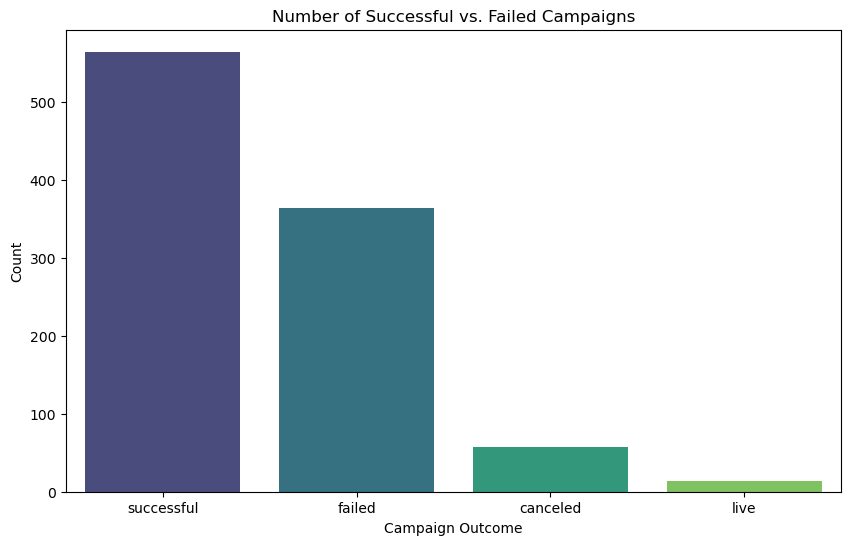

In [20]:
# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_outcome, x='outcome', y='count', palette='viridis')
plt.title('Number of Successful vs. Failed Campaigns')
plt.xlabel('Campaign Outcome')
plt.ylabel('Count')

# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/outcome_plot.png')

plt.show()

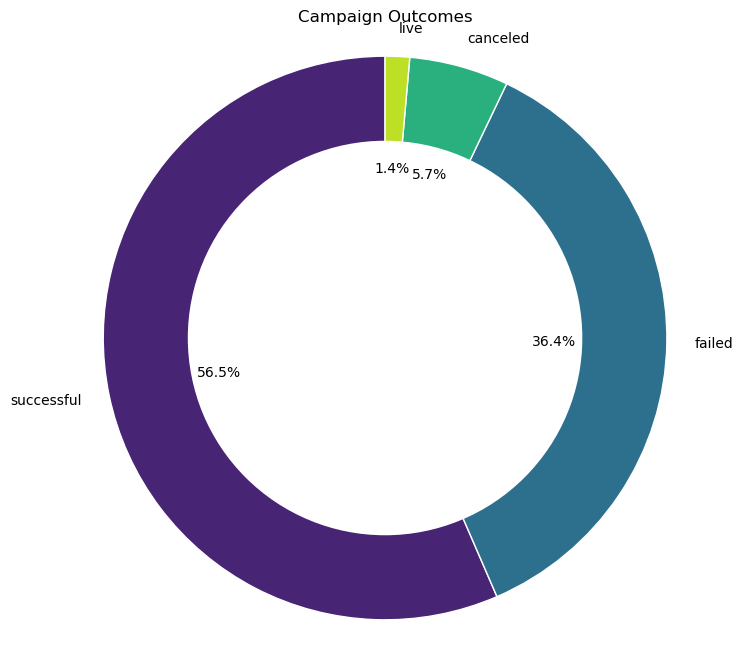

In [21]:
# Plotting the donut chart
# define labels 
labels = df_outcome['outcome'].tolist()
sizes = df_outcome['count'].tolist()
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(labels)))
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'})
# Draw a circle to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Add title
plt.title('Campaign Outcomes')
# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/outcome_donut.png')

# Display the plot
plt.show()

In [22]:
# SQL query to count successful campaigns by category and subcategory
query_category = """
SELECT 
    category_id, 
    COUNT(*) as count
FROM 
    campaign
WHERE 
    outcome = 'successful'
GROUP BY 
    category_id
ORDER BY 
    count DESC
"""

# Execute the query and load the data into a pandas DataFrame
with engine.connect() as connection:
    result = connection.execute(text(query_category))
    category_df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Display the data
category_df.head()

,category_id,count
0,cat4,187
1,cat5,102
2,cat2,99
3,cat3,64
4,cat6,40


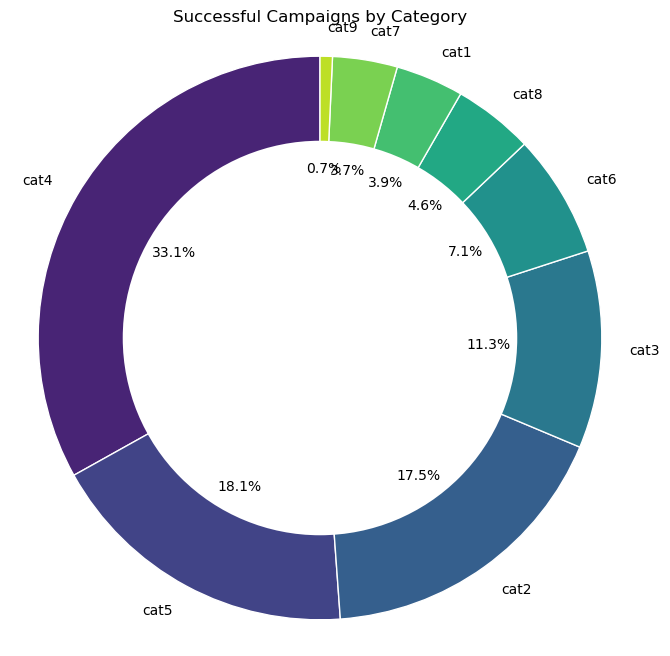

In [23]:
# define labels 
labels = category_df['category_id'].tolist()
sizes = category_df['count'].tolist()
# Custom colors for the donut chart
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(labels)))

# Plotting the donut chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'})

# Adding a circle at the center to create a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Adding title
plt.title('Successful Campaigns by Category')
# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/category_donut.png')

# Display the plot
plt.show()

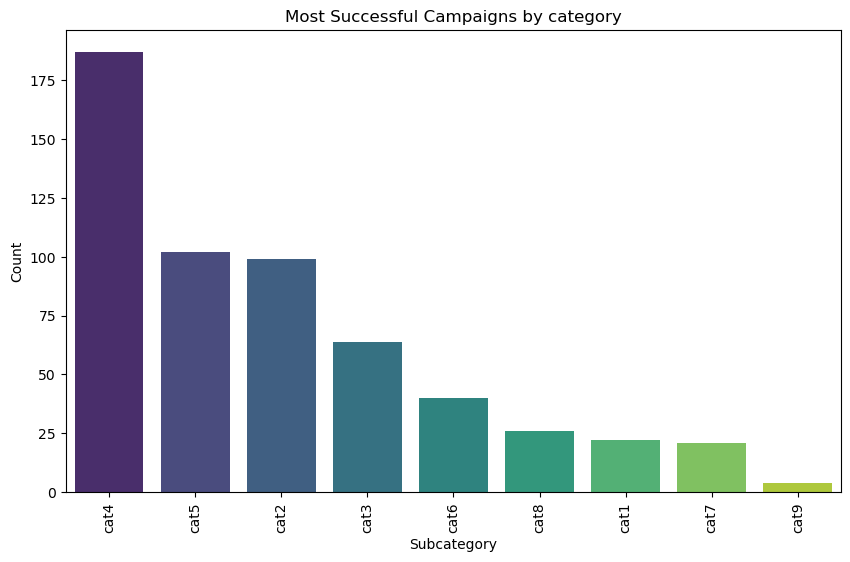

In [24]:
# Ensure the 'output' directory exists
os.makedirs('output', exist_ok=True)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=category_df, x='category_id', y='count', palette='viridis')
plt.title('Most Successful Campaigns by category')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels and set font size

# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/category_plot.png')
plt.show()

In [25]:
# SQL query to count successful campaigns by category and subcategory
query_subcategory = """
SELECT 
    subcategory_id, 
    COUNT(*) as count
FROM 
    campaign
WHERE 
    outcome = 'successful'
GROUP BY 
    subcategory_id
ORDER BY 
    count DESC
"""

# Execute the query and load the data into a pandas DataFrame
with engine.connect() as connection:
    result = connection.execute(text(query_subcategory))
    subcategory_df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Display the data
subcategory_df.head(10)

,subcategory_id,count
0,subcat4,187
1,subcat2,49
2,subcat3,36
3,subcat5,34
4,subcat9,28
5,subcat15,26
6,subcat8,23
7,subcat1,22
8,subcat7,22
9,subcat11,21


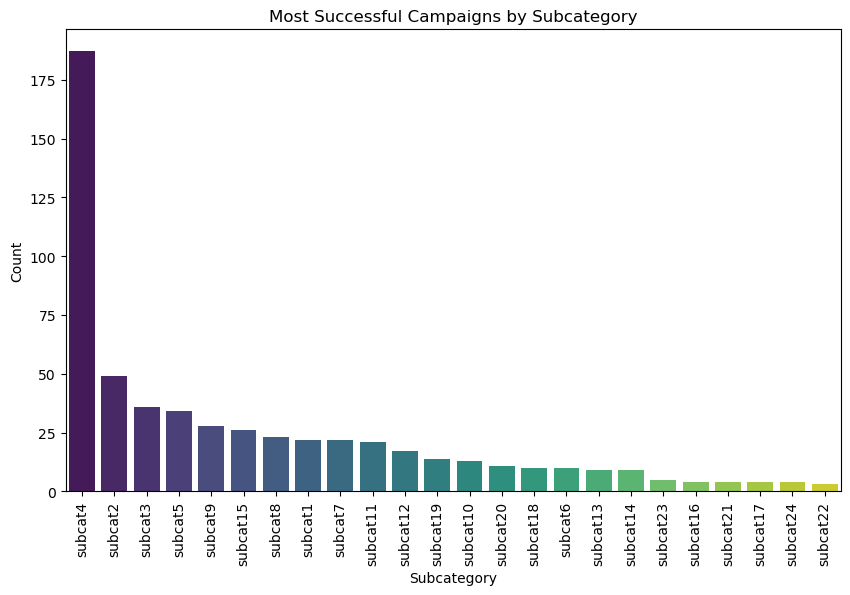

In [26]:
# Ensure the 'output' directory exists
os.makedirs('output', exist_ok=True)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=subcategory_df, x='subcategory_id', y='count', palette='viridis')
plt.title('Most Successful Campaigns by Subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels and set font size

# Save the plot as an image file (e.g., PNG format)
plt.savefig('output/subcategory_plot.png')
plt.show()

In [27]:
# Query 3 - How do the goals and number of backers compare between successful and failed campaigns?

# Select all rows in goal and backers_count that were failed in outcome and create a df
query = """
SELECT goal, backers_count
FROM campaign
WHERE outcome = 'failed';
"""
failed_df = pd.read_sql(text(query), con=engine)
failed_df

,goal,backers_count
0,100.0,0
1,4200.0,24
2,7600.0,53
3,5200.0,18
4,6200.0,44
...,...,...
359,9400.0,64
360,7800.0,64
361,141100.0,842
362,6600.0,112


In [28]:
# Select all rows in goal and backers_count that were successful in outcome and create a df
query = """
SELECT goal, backers_count
FROM campaign
WHERE outcome = 'successful';
"""
successful_df = pd.read_sql(text(query), con=engine)
successful_df

,goal,backers_count
0,1400.0,158
1,108400.0,1425
2,7600.0,174
3,4500.0,227
4,5200.0,220
...,...,...
560,6200.0,480
561,2400.0,226
562,9800.0,241
563,3100.0,132


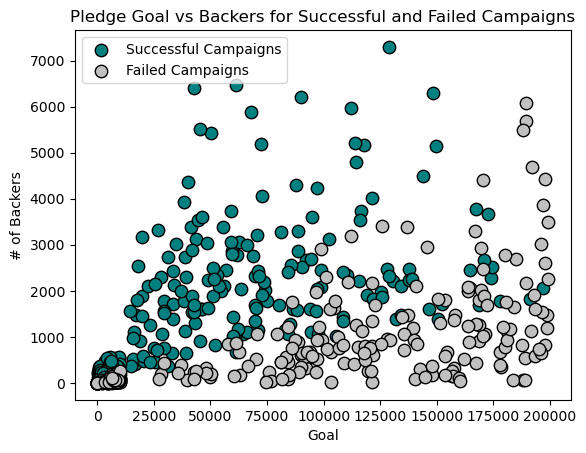

In [29]:
# Combine the two scatterplots
# Create first scatter plot within the 'ax' element
ax = successful_df.plot.scatter(x='goal', y='backers_count', color='teal', edgecolor='black', s=80, label='Successful Campaigns')

# Create second scatter plot, using 'ax' element
failed_df.plot.scatter(x='goal', y='backers_count', color='silver', edgecolor='black', s=80, label='Failed Campaigns', ax=ax)

# Title and labels
plt.xlabel('Goal')
plt.ylabel('# of Backers')
plt.title('Pledge Goal vs Backers for Successful and Failed Campaigns')

# Show
plt.show()